# Experiments for NIPS 2016
---

In [2]:
# import the modules
import os
import sys
import GPy
import csv
import time
import random
import argparse
import numpy as np
from os import listdir
import cPickle as pickle
from matplotlib import cm
from tabulate import tabulate
from os.path import isfile, join
from sklearn import preprocessing
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from GPy.plotting.matplot_dep.controllers.imshow_controller import ImshowController
from GPy.inference.latent_function_inference import InferenceMethodList, VarDTC, VarDTC_minibatch

%matplotlib notebook

## Dataset Preprocessing
---

Preprocess dataset of demonstrations and store in pickle files

In [10]:
# directories with dataset
jaDir = 'Data/JA/'
eeDir = 'Data/EE/'
ikDir = 'Data/IK/'

# get file names in directories
jaFiles = [f for f in listdir(jaDir) if isfile(join(jaDir, f))]
eeFiles = [f for f in listdir(eeDir) if isfile(join(eeDir, f))]
ikFiles = [f for f in listdir(ikDir) if isfile(join(ikDir, f))]

# use only the teach files
jaFiles = [jaFile for jaFile in jaFiles if "teach" in jaFile]
eeFiles = [eeFile for eeFile in eeFiles if "teach" in eeFile]
ikFiles = [ikFile for ikFile in ikFiles if "teach" in ikFile]

# get the file headers
jaData = np.genfromtxt('%s%s' % (jaDir, jaFiles[0]), delimiter=',', names=True)
eeData = np.genfromtxt('%s%s' % (eeDir, eeFiles[0]), delimiter=',', names=True)
ikData = np.genfromtxt('%s%s' % (ikDir, ikFiles[0]), delimiter=',', names=True)

# get single header string
jaHeader = ','.join(map(str, jaData.dtype.names))
eeHeader = ','.join(map(str, eeData.dtype.names))
ikHeader = ','.join(map(str, ikData.dtype.names))

# load the data to dictionary
data = {'JA':{},'EE':{}, 'IK':{}}
for jaFile,eeFile,ikFile in zip(jaFiles,eeFiles,ikFiles):
    # load the files
    jaData = np.genfromtxt('%s%s' % (jaDir, jaFile), delimiter=',', skip_header=1)
    eeData = np.genfromtxt('%s%s' % (eeDir, eeFile), delimiter=',', skip_header=1)
    ikData = np.genfromtxt('%s%s' % (ikDir, ikFile), delimiter=',', skip_header=1)
    
    # push into dictionary
    data['JA'][jaFile[3:5]] = jaData
    data['EE'][eeFile[3:5]] = eeData[:,:15]
    data['IK'][ikFile[3:5]] = ikData
    
pickle.dump(data, open('Data/Data.p','wb'))

In [11]:
# partition to training and test data
testInds = [75]
trainInds = [65,70,80]

# training data
trData = {'T':np.empty((0,1)),'JA':np.empty((0,14)),
          'EE':np.empty((0,14)),'IK':np.empty((0,14))}

for trInd in trainInds:
    jaDat = data['JA']['%d' % (trInd)][:,1:]
    eeDat = data['EE']['%d' % (trInd)][:,1:]
    ikDat = data['IK']['%d' % (trInd)][:,1:]
    tDat = np.atleast_2d(data['JA']['%d' % (trInd)][:,0]).T
    
    trData['T'] = np.vstack((trData['T'],tDat))
    trData['JA'] = np.vstack((trData['JA'],jaDat))
    trData['EE'] = np.vstack((trData['EE'],eeDat))
    trData['IK'] = np.vstack((trData['IK'],ikDat))

# test data
tsData = {'T':np.empty((0,1)),'JA':np.empty((0,14)),
          'EE':np.empty((0,14)),'IK':np.empty((0,14))}
for tsInd in testInds:
    jaDat = data['JA']['%d' % (tsInd)][:,1:]
    eeDat = data['EE']['%d' % (tsInd)][:,1:]
    ikDat = data['IK']['%d' % (tsInd)][:,1:]
    tDat = np.atleast_2d(data['JA']['%d' % (tsInd)][:,0]).T
    
    tsData['T'] = np.vstack((tsData['T'],tDat))
    tsData['JA'] = np.vstack((tsData['JA'],jaDat))
    tsData['EE'] = np.vstack((tsData['EE'],eeDat))
    tsData['IK'] = np.vstack((tsData['IK'],ikDat))

# normalize the ja, ik and ee data
trData['JANorm'] = (trData['JA'] - trData['JA'].mean(0))/trData['JA'].std(0)
trData['EENorm'] = (trData['EE'] - trData['EE'].mean(0))/trData['EE'].std(0)
trData['IKNorm'] = (trData['IK'] - trData['IK'].mean(0))/trData['IK'].std(0)

tsData['JANorm'] = (tsData['JA'] - trData['JA'].mean(0))/trData['JA'].std(0)
tsData['EENorm'] = (tsData['EE'] - trData['EE'].mean(0))/trData['EE'].std(0)
tsData['IKNorm'] = (tsData['IK'] - trData['IK'].mean(0))/trData['IK'].std(0)

# save variables to pickle files
pickle.dump(tsData, open('Data/TestData.p','wb'))
pickle.dump(trData, open('Data/TrainData.p','wb'))

## Model Training Functions
---

In [12]:
# function to train pca model
def pcaModel(data, expName, qDim=2):
    # apply PCA
    model = PCA(n_components=qDim)
    model.fit(data)

    # get latent points and scales
    xData = model.transform(data)
    scales = model.explained_variance_ratio_
    scales = scales/scales.max()

    output = {'model':model, 'latent':xData, 'scales':scales}
    
    # return model variables
    return output

In [13]:
# function to train gplvm model
def gplvmModel(data, expName, qDim=2, initIters=100, trainIters=1000):
    # model train variables
    SNR = 100

    # initialize latent space
    pca = PCA(n_components=qDim)
    pca.fit(data)

    # get latent points and scales
    xData = pca.transform(data)
    scales = pca.explained_variance_ratio_
    scales = scales/scales.max()

    # setting up the kernel
    kernel = GPy.kern.RBF(qDim, variance=1., lengthscale=1.)

    # initialize BGPLVM model
    model = GPy.models.GPLVM(data, input_dim=qDim, kernel=kernel, X=xData, name=expName)

    # train with constriants
    var = model.Y.var()
    model.rbf.variance.fix(var)
    model.rbf.lengthscale.fix(1.0)
    model.Gaussian_noise.variance.fix(var/SNR)
    model.optimize(messages = True, max_iters = initIters)

    # train without constraints
    model.unconstrain_fixed()
    model.optimize(messages = True, max_iters = trainIters)
    
    # return model
    return model

In [14]:
# function to train bgplvm model
def bgplvmModel(data, expName, qDim=5, initIters=100, trainIters=1000):
    # model init variables
    nInducing = 100

    # model train variables
    SNR = 100

    # initialize latent space
    pca = PCA(n_components=qDim)
    pca.fit(data)

    # get latent points and scales
    xData = pca.transform(data)
    scales = pca.explained_variance_ratio_
    scales = scales/scales.max()

    # setting up the kernel
    kernel = GPy.kern.RBF(qDim, variance=1., lengthscale=1./scales, ARD=True)

    # initialize BGPLVM model
    model = GPy.models.BayesianGPLVM(data, input_dim=qDim, num_inducing=nInducing, kernel=kernel, X=xData,
                                     name=expName)

    # train with constriants
    var = model.Y.var()
    model.rbf.variance.fix(var)
    #model.rbf.lengthscale.fix(1./scales)
    model.Gaussian_noise.variance.fix(var/SNR)
    model.optimize(messages = True, max_iters = initIters)

    # train without constraints
    model.unconstrain_fixed()
    model.optimize(messages = True, max_iters = trainIters)
    
    # return model
    return model

In [15]:
def plotScales(model, yThresh=0.05):
    # get ARD weight parameters
    scales = model.kern.input_sensitivity(summarize=False)
    scales =  scales/scales.max()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    x = np.arange(1,scales.shape[0]+1)
    ax.bar(x, height=scales, width=0.8, align='center', color='b', edgecolor='k', linewidth=1.3)
    ax.plot([0.4, scales.shape[0]+0.6], [yThresh, yThresh], '--', linewidth=3, color='r')

    # setting the bar plot parameters
    ax.set_xlim(.4, scales.shape[0]+.6)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xticks(xrange(1,scales.shape[0]+1))
    ax.set_title(model.name, fontsize=25)
    ax.set_ylabel('ARD Weight', fontsize=20)
    ax.set_xlabel('Latent Dimensions', fontsize=20)

    return ax

In [16]:
def plotLatent(model, plotIndices=[0,1], maxPoints=600, plotVariance=True, labels=None):
    s = 100
    marker = 'o'
    resolution = 50

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # get latent space plot parameters
    latentData = model.X.mean
    qDim = model.X.mean.shape[1]
    input1, input2 = plotIndices
    nSamples = model.X.mean.shape[0]
    
    # create the labels
    if labels == None:
        labels = [(0,0,1)]*nSamples
    
    # subsample latent points for easier visualization
    if latentData.shape[0] > maxPoints:
        subsample = np.random.choice(latentData.shape[0], size=maxPoints, replace=False)
        latentData = latentData[subsample]

    # compute plot limits
    xmin, ymin = latentData[:, [input1, input2]].min(0)
    xmax, ymax = latentData[:, [input1, input2]].max(0)
    x_r, y_r = xmax-xmin, ymax-ymin
    xmin -= .1*x_r
    xmax += .1*x_r
    ymin -= .1*y_r
    ymax += .1*y_r

    # plot the variance for the model
    def plotFunction(x):
        Xtest_full = np.zeros((x.shape[0], qDim))
        Xtest_full[:, [input1, input2]] = x
        _, var = model.predict(np.atleast_2d(Xtest_full))
        var = var[:, :1]
        return -np.log(var)

    x, y = np.mgrid[xmin:xmax:1j*resolution, ymin:ymax:1j*resolution]
    gridData = np.hstack((x.flatten()[:, None], y.flatten()[:, None]))
    gridVariance = (plotFunction(gridData)).reshape((resolution, resolution))

    varianceHandle = plt.imshow(gridVariance.T, interpolation='bilinear', origin='lower', cmap=cm.gray,
                                extent=(xmin, xmax, ymin, ymax))

    dataHandle = ax.scatter(latentData[:, input1], latentData[:, input2], marker=marker, s=s, c=labels, 
                            linewidth=.2, edgecolor='k', alpha=1.)

    ax.grid(b=False)
    ax.set_aspect('auto')
    ax.set_title(model.name, fontsize=25)
    ax.tick_params(axis='both', labelsize=20)
    # ax.legend([trainH,testH],['Train','Test'],loc=1,fontsize=20)
    ax.set_xlabel('Latent Dimension %i' % (input1+1), fontsize=20)
    ax.set_ylabel('Latent Dimension %i' % (input2+1), fontsize=20)

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    fig.canvas.draw()
    fig.tight_layout()
    fig.canvas.draw()
    plt.show()

    return ax

## Model Training
---

In [17]:
# load the processed dataset
tsData = pickle.load(open('Data/TestData.p','r'))
trData = pickle.load(open('Data/TrainData.p','r'))

# create plot variables
nPoints = 150
labels = [(0,0,1)]*(nPoints/3)+[(0,1,0)]*(nPoints/3)+[(1,0,0)]*(nPoints/3)

<IPython.core.display.Javascript object>


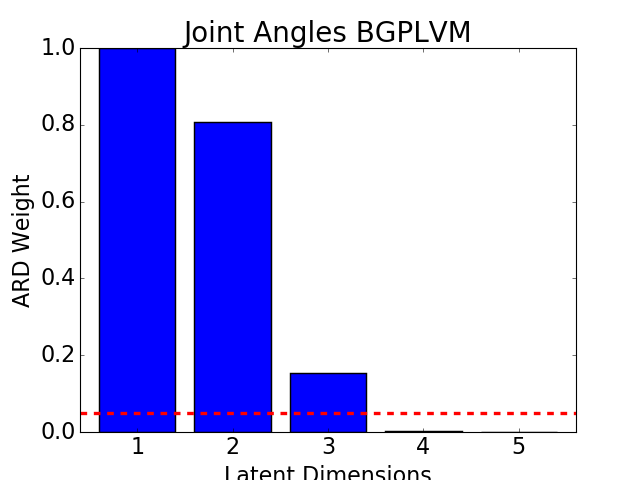

<IPython.core.display.Javascript object>


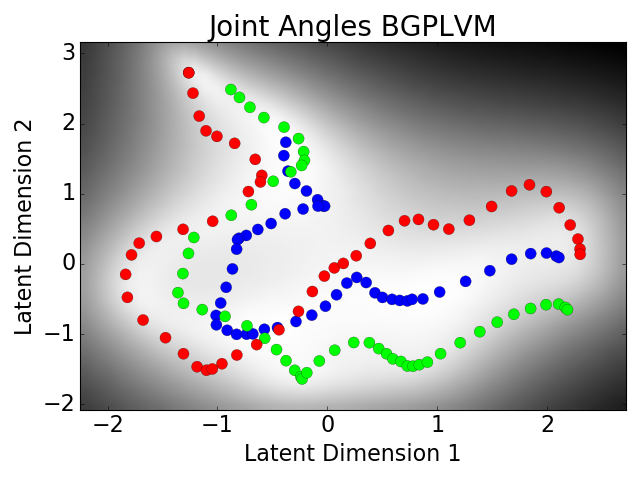

In [18]:
# data variables
trainData = trData['JA']

# downsample points
nMaxPoints = trainData.shape[0]
indices = np.linspace(0, nMaxPoints-1, num=nPoints, endpoint=True, dtype=np.int)
trainData = trainData[indices,:]

# train the models
jaModels = {}

expName = 'Joint Angles PCA'
jaModels['PCA'] = pcaModel(trainData,expName,qDim=3)

expName = 'Joint Angles GPLVM'
jaModels['GPLVM'] = gplvmModel(trainData,expName,qDim=3)

expName = 'Joint Angles BGPLVM'
jaModels['BGPLVM'] = bgplvmModel(trainData,expName)

# visualize the model
plotScales(jaModels['BGPLVM'])
plotLatent(jaModels['BGPLVM'], plotIndices=[0,1], labels=labels, maxPoints=1200)

# save the model to file
pickle.dump(jaModels,open('Results/JAModels.p','wb'))

<IPython.core.display.Javascript object>


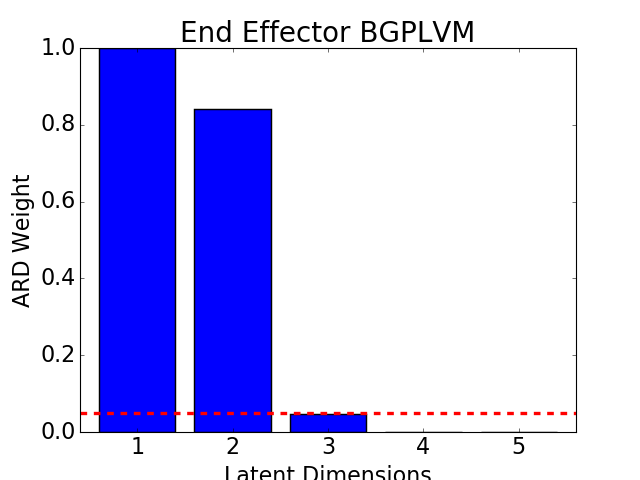

<IPython.core.display.Javascript object>


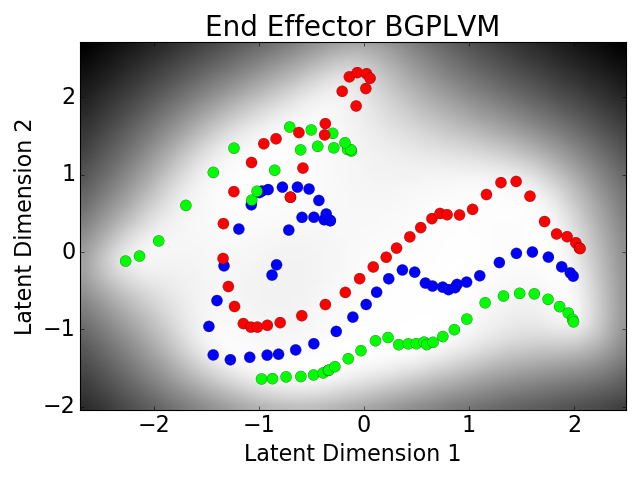

In [19]:
# data variables
trainData = trData['EE']

# downsample points
nMaxPoints = trainData.shape[0]
indices = np.linspace(0, nMaxPoints-1, num=nPoints, endpoint=True, dtype=np.int)
trainData = trainData[indices,:]

# train the models
eeModels = {}

expName = 'End Effector PCA'
eeModels['PCA'] = pcaModel(trainData,expName)

expName = 'End Effector GPLVM'
eeModels['GPLVM'] = gplvmModel(trainData,expName)

expName = 'End Effector BGPLVM'
eeModels['BGPLVM'] = bgplvmModel(trainData,expName)

# visualize the model
plotScales(eeModels['BGPLVM'])
plotLatent(eeModels['BGPLVM'], plotIndices=[0,1], labels=labels, maxPoints=1200)

# save the model to file
pickle.dump(eeModels,open('Results/EEModels.p','wb'))

## Reconstruction Error Functions
---

In [12]:
# function to compute test and training reconstruction error
def pcaError(pcaModel, trainData, testData):
    # get number of test and training samples
    nTest = testData.shape[0]
    nTrain = trainData.shape[0]
    nDims = trainData.shape[1]
    
    model = pcaModel['model']
    
    # create output variables
    testLatent = model.transform(testData)
    trainLatent = model.transform(trainData)
    
    testOut = model.inverse_transform(testLatent)
    trainOut = model.inverse_transform(trainLatent)
    
    testError = np.zeros((nTest,1))
    trainError = np.zeros((nTrain,1))
    
    # compute reconstruction error
    testError = np.sqrt(((testData - testOut)**2).sum(axis=1)/nDims)
    trainError = np.sqrt(((trainData - trainOut)**2).sum(axis=1)/nDims)
    
    # return the variables
    return (trainLatent, testLatent, trainOut, testOut, trainError, testError)

In [13]:
# function to compute test and training reconstruction error
def gplvmError(model, trainData, testData):
    # get number of test and training samples
    nTest = testData.shape[0]
    nTrain = trainData.shape[0]
    
    nDims = trainData.shape[1]
    qDims = model.X.shape[1]
        
    # create output variables
    testOut = np.zeros((nTest,nDims))
    trainOut = np.zeros((nTrain,nDims))
    
    testLatent = np.zeros((nTest,qDims))
    trainLatent = np.zeros((nTrain,qDims))
    
    testError = np.zeros((nTest,1))
    trainError = np.zeros((nTrain,1))
    
    # loop over training data
    for n in range(nTrain):
        # infer latent position
        xTrain, _ = model.infer_newX(np.atleast_2d(trainData[n,:]),optimize=True)
        
        # update parameter
        trainLatent[n,:] = xTrain
        
        # infer high dimensional output
        yOut = model.predict(xTrain)
        trainOut[n,:] = yOut[0]
        sys.stdout.write('.')
    sys.stdout.write('\n')
    
    # loop over test data
    for n in range(nTest):
        # infer latent position
        xTest, _ = model.infer_newX(np.atleast_2d(testData[n,:]),optimize=True)
        
        # update parameter
        testLatent[n,:] = xTest
        
        # infer high dimensional output
        yOut = model.predict(xTest)
        testOut[n,:] = yOut[0]
        sys.stdout.write('.')
    sys.stdout.write('\n')
        
    # compute reconstruction error
    testError = np.sqrt(((testData - testOut)**2).sum(axis=1)/nDims)
    trainError = np.sqrt(((trainData - trainOut)**2).sum(axis=1)/nDims)
    
    # return the variables
    return (trainLatent, testLatent, trainOut, testOut, trainError, testError)

In [14]:
# function to compute test and training reconstruction error
def bgplvmError(model, trainData, testData, wThresh=0.05):
    # get number of test and training samples
    nTest = testData.shape[0]
    nTrain = trainData.shape[0]
    
    nDims = trainData.shape[1]
    qDims = model.X.mean.shape[1]
    
    # get active dimensions
    scales = model.kern.input_sensitivity(summarize=False)
    scales = scales/scales.max()
    inactiveDims = np.where(scales <= wThresh)
    
    # create output variables
    testOut = np.zeros((nTest,nDims))
    trainOut = np.zeros((nTrain,nDims))
    
    testLatent = np.zeros((nTest,qDims))
    trainLatent = np.zeros((nTrain,qDims))
    
    testError = np.zeros((nTest,1))
    trainError = np.zeros((nTrain,1))
    
    # loop over training data
    for n in range(nTrain):
        # infer latent position
        xTrain, _ = model.infer_newX(np.atleast_2d(trainData[n,:]),optimize=True)
        
        # update parameter
        xTrain.mean[0,inactiveDims[0]] = 0.0
        trainLatent[n,:] = xTrain.mean
        
        # infer high dimensional output
        yOut = model.predict(xTrain.mean)
        trainOut[n,:] = yOut[0]
        sys.stdout.write('.')
    sys.stdout.write('\n')
    
    # loop over test data
    for n in range(nTest):
        # infer latent position
        xTest, _ = model.infer_newX(np.atleast_2d(testData[n,:]),optimize=True)
        
        # update parameter
        xTest.mean[0,inactiveDims[0]] = 0.0
        testLatent[n,:] = xTest.mean
        
        # infer high dimensional output
        yOut = model.predict(xTest.mean)
        testOut[n,:] = yOut[0]
        sys.stdout.write('.')
    sys.stdout.write('\n')
    
    # compute reconstruction error
    testError = np.sqrt(((testData - testOut)**2).sum(axis=1)/nDims)
    trainError = np.sqrt(((trainData - trainOut)**2).sum(axis=1)/nDims)
    
    # return the variables
    return (trainLatent, testLatent, trainOut, testOut, trainError, testError)

## Compute Reconstruction Error
---

In [15]:
# load the processed dataset
tsData = pickle.load(open('Data/TestData.p','r'))
trData = pickle.load(open('Data/TrainData.p','r'))

# variable for test points
nInfPoints = 400
nTestPoints = nInfPoints
nTrainPoints = 3*nInfPoints

# downsample points
testJAData = tsData['JA']
trainJAData = trData['JA']

testEEData = tsData['EE']
trainEEData = trData['EE']

nTestMaxPoints = tsData['JA'].shape[0]
nTrainMaxPoints = trData['JA'].shape[0]
testIndices = np.linspace(0, nTestMaxPoints-1, num=nTestPoints, endpoint=True, dtype=np.int)
trainIndices = np.linspace(0, nTrainMaxPoints-1, num=nTrainPoints, endpoint=True, dtype=np.int)

testJAData = testJAData[testIndices,:]
trainJAData = trainJAData[trainIndices,:]

testEEData = testEEData[testIndices,:]
trainEEData = trainEEData[trainIndices,:]

In [16]:
# load the ja and ee models
jaModels = pickle.load(open('Results/JAModels.p','r'))
eeModels = pickle.load(open('Results/EEModels.p','r'))

# compute recontruction error and test inference for models
jaOutputs = {}
jaOutputs['PCA'] = pcaError(jaModels['PCA'], trainJAData, testJAData)
jaOutputs['GPLVM'] = gplvmError(jaModels['GPLVM'], trainJAData, testJAData)
jaOutputs['BGPLVM'] = bgplvmError(jaModels['BGPLVM'], trainJAData, testJAData)

eeOutputs = {}
eeOutputs['PCA'] = pcaError(eeModels['PCA'], trainEEData, testEEData)
eeOutputs['GPLVM'] = gplvmError(eeModels['GPLVM'], trainEEData, testEEData)
eeOutputs['BGPLVM'] = bgplvmError(eeModels['BGPLVM'], trainEEData, testEEData)

# save results to pickle file
pickle.dump(jaOutputs, open('Results/JAResults.p','wb'))
pickle.dump(eeOutputs, open('Results/EEResults.p','wb'))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [3]:
# load variables of interest
jaOutputs = pickle.load(open('Results/JAResults.p','rb'))
eeOutputs = pickle.load(open('Results/EEResults.p','rb'))

# variables of interest
jaMeanTestErrors = [jaOutputs['PCA'][5].mean(0), jaOutputs['GPLVM'][5].mean(0),
                jaOutputs['BGPLVM'][5].mean(0)]
jaMeanTrainErrors = [jaOutputs['PCA'][4].mean(0), jaOutputs['GPLVM'][4].mean(0),
                 jaOutputs['BGPLVM'][4].mean(0)]
eeMeanTestErrors = [eeOutputs['PCA'][5].mean(0), eeOutputs['GPLVM'][5].mean(0),
                eeOutputs['BGPLVM'][5].mean(0)]
eeMeanTrainErrors = [eeOutputs['PCA'][4].mean(0), eeOutputs['GPLVM'][4].mean(0),
                eeOutputs['BGPLVM'][4].mean(0)]

jaVarTestErrors = [jaOutputs['PCA'][5].std(0), jaOutputs['GPLVM'][5].std(0),
                jaOutputs['BGPLVM'][5].std(0)]
jaVarTrainErrors = [jaOutputs['PCA'][4].std(0), jaOutputs['GPLVM'][4].std(0),
                 jaOutputs['BGPLVM'][4].std(0)]
eeVarTestErrors = [eeOutputs['PCA'][5].std(0), eeOutputs['GPLVM'][5].std(0),
                eeOutputs['BGPLVM'][5].std(0)]
eeVarTrainErrors = [eeOutputs['PCA'][4].std(0), eeOutputs['GPLVM'][4].std(0),
                eeOutputs['BGPLVM'][4].std(0)]

# print the results
print 'JA Train Error: ', jaMeanTrainErrors
print 'JA Test Error: ', jaMeanTestErrors

print 'EE Train Error: ', eeMeanTrainErrors
print 'EE Test Error: ', eeMeanTestErrors

JA Train Error:  [0.088555880240582169, 0.0043735131084481453, 0.010338740347587446]
JA Test Error:  [0.10194820007210048, 0.093666610049674054, 0.090182808144093199]
EE Train Error:  [0.023873393131109141, 0.0015161248311661791, 0.017630599910099694]
EE Test Error:  [0.022519950199183542, 0.020802822438464905, 0.021700405297136783]


In [6]:
# function to plot error bars
def plotErrorBars(mE, vE, xLabels, legend, colors, ylabel='NRMSE', 
                  legendLoc=3, title='Comparison', ylimit=[0.,1.], 
                  xlimit=[-0.1,2.1]):
    
    fontSize = 25
    N = mE.shape[1]
    
    widthFull = 0.8
    width = widthFull/N       
    buffer = (1.0 - widthFull)/2.0
    
    ind = np.arange(mE.shape[0])  
    fig, ax = plt.subplots()
    
    for i in range(mE.shape[1]):
        err = ax.bar(buffer+ind+i*width, mE[:,i], yerr=vE[:,i], width=width, color=colors[i], ecolor='k')
    
    ax.set_ylim(ylimit)
    ax.set_xlim(xlimit)
    ax.set_xticks(ind + 0.5)
    ax.set_ylabel(ylabel, fontsize=fontSize)
    ax.legend(legend, loc=legendLoc, fontsize=fontSize, prop = {'size':fontSize-5})
    ax.set_xticklabels(xLabels, fontsize=fontSize-5)
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-5)

    plt.show()

(2, 3) (2, 3)


<IPython.core.display.Javascript object>


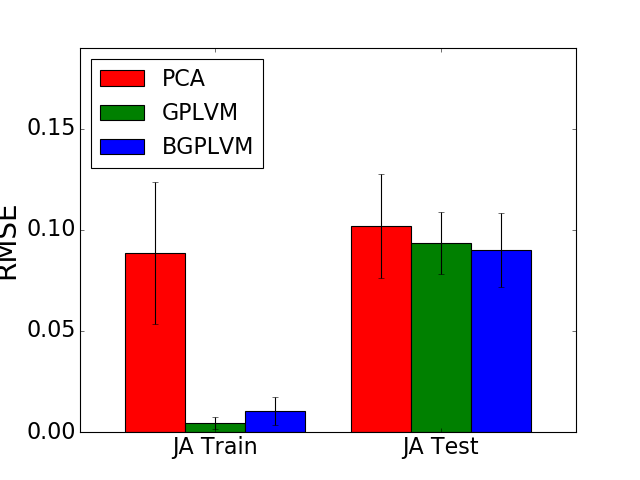

In [7]:
# plot the error bars
xLabels = ['JA Train','JA Test']#, 'EE Train', 'EE Test']
legend = ['PCA','GPLVM','BGPLVM']
colors = ['r','g','b']

mE = np.asarray([jaMeanTrainErrors, jaMeanTestErrors])
                 #eeMeanTrainErrors, eeMeanTestErrors])
vE = np.asarray([jaVarTrainErrors, jaVarTestErrors])
                 #eeVarTrainErrors, eeVarTestErrors])
    
print mE.shape, vE.shape
plotErrorBars(mE, vE, xLabels, legend, colors, ylabel='RMSE',
              title='Model Comparison', ylimit=[0.0,0.19], legendLoc=2)
plt.savefig('Results/rmse.pdf', format='pdf')

## Plot Functions
---

In [20]:
def plotScales(model, yThresh=0.05):
    # get ARD weight parameters
    scales = model.kern.input_sensitivity(summarize=False)
    scales =  scales/scales.max()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    x = np.arange(1,scales.shape[0]+1)
    ax.bar(x, height=scales, width=0.8, align='center', color='b', edgecolor='k', linewidth=1.3)
    ax.plot([0.4, scales.shape[0]+0.6], [yThresh, yThresh], '--', linewidth=3, color='r')

    # setting the bar plot parameters
    ax.set_xlim(.4, scales.shape[0]+.6)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xticks(xrange(1,scales.shape[0]+1))
    ax.set_title(model.name, fontsize=25)
    ax.set_ylabel('ARD Weight', fontsize=20)
    ax.set_xlabel('Latent Dimensions', fontsize=20)

    plt.show()
    return ax

In [21]:
def pcaLatent(pcaModel, trainInput, testInput, nPoints=100):
    sTest = 200
    sTrain = 150
    resolution = 50

    testMarker = 's'
    trainMarker = 'o'
    
    testLabels = [(1,0,0)]*nPoints
    trainLabels = [(0,0,1)]*nPoints + [(0,0,1)]*nPoints + [(0,0,1)]*nPoints
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # get latent space plot parameters
    model = pcaModel['model']

    # test data latent inference
    testData = model.transform(testInput)    
    trainData = model.transform(trainInput)

    # variables for plotting
    plotIndices = [0, 1]
    qDim = trainData.shape[1]
    input1, input2 = plotIndices
        
    # compute plot limits
    xmin, ymin = trainData[:, [input1, input2]].min(0)
    xmax, ymax = trainData[:, [input1, input2]].max(0)
    x_r, y_r = xmax-xmin, ymax-ymin
    xmin -= .1*x_r
    xmax += .1*x_r
    ymin -= .1*y_r
    ymax += .1*y_r

    testHandle = ax.scatter(testData[:, input1], testData[:, input2], marker=testMarker, s=sTest, c=testLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)
    trainHandle = ax.scatter(trainData[:, input1], trainData[:, input2], marker=trainMarker, s=sTrain, c=trainLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)

    ax.grid(b=False)
    ax.set_aspect('auto')
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Latent Dimension %i' % (input1+1), fontsize=25, fontweight='bold')
    ax.set_ylabel('Latent Dimension %i' % (input2+1), fontsize=25, fontweight='bold')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    properties = {'weight':'bold','size':25}
    plt.legend([trainHandle, testHandle], ['Train', 'Test'], prop=properties)
    
    fig.canvas.draw()
    fig.tight_layout()
    fig.canvas.draw()
    plt.show()

    return ax

In [22]:
def gplvmLatent(model, trainInput, testInput, nPoints):
    sTest = 200
    sTrain = 150
    resolution = 50

    testMarker = 's'
    trainMarker = 'o'
    
    testLabels = [(1,0,0)]*nPoints
    trainLabels = [(0,0,1)]*nPoints + [(0,0,1)]*nPoints + [(0,0,1)]*nPoints
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # variables for plotting
    plotIndices = [0,1]
    qDim = model.X.shape[1]
    input1, input2 = plotIndices

    # loop over test data
    testData = np.zeros((testInput.shape[0], qDim))
    trainData = np.zeros((trainInput.shape[0], qDim))
    
    for n in range(trainInput.shape[0]):
        # infer latent position
        xTrain, _ = model.infer_newX(np.atleast_2d(trainInput[n,:]), optimize=True)
        
        # update parameter
        trainData[n,:] = xTrain
        sys.stdout.write('.') 
    sys.stdout.write('\n')
    
    for n in range(testInput.shape[0]):
        # infer latent position
        xTest, _ = model.infer_newX(np.atleast_2d(testInput[n,:]), optimize=True)
        
        # update parameter
        testData[n,:] = xTest
        sys.stdout.write('.') 
    sys.stdout.write('\n')

    # compute plot limits
    xmin, ymin = trainData[:, [input1, input2]].min(0)
    xmax, ymax = trainData[:, [input1, input2]].max(0)
    x_r, y_r = xmax-xmin, ymax-ymin
    xmin -= .1*x_r
    xmax += .1*x_r
    ymin -= .1*y_r
    ymax += .1*y_r

    # plot the variance for the model
    def plotFunction(x):
        Xtest_full = np.zeros((x.shape[0], qDim))
        Xtest_full[:, [input1, input2]] = x
        _, var = model.predict(np.atleast_2d(Xtest_full))
        var = var[:, :1]
        return -np.log(var)

    x, y = np.mgrid[xmin:xmax:1j*resolution, ymin:ymax:1j*resolution]
    gridData = np.hstack((x.flatten()[:, None], y.flatten()[:, None]))
    gridVariance = (plotFunction(gridData)).reshape((resolution, resolution))

    varianceHandle = plt.imshow(gridVariance.T, interpolation='bilinear', origin='lower', cmap=cm.gray,
                                extent=(xmin, xmax, ymin, ymax))

    # test and training plotting
    testHandle = ax.scatter(testData[:, input1], testData[:, input2], marker=testMarker, s=sTest, c=testLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)
    trainHandle = ax.scatter(trainData[:, input1], trainData[:, input2], marker=trainMarker, s=sTrain, c=trainLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)

    ax.grid(b=False)
    ax.set_aspect('auto')
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Latent Dimension %i' % (input1+1), fontsize=25, fontweight='bold')
    ax.set_ylabel('Latent Dimension %i' % (input2+1), fontsize=25, fontweight='bold')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    properties = {'weight':'bold','size':25}
    plt.legend([trainHandle, testHandle], ['Train', 'Test'], prop=properties)
    
    fig.canvas.draw()
    fig.tight_layout()
    fig.canvas.draw()
    plt.show()

    return ax

In [23]:
def bgplvmLatent(model, trainInput, testInput, nPoints):
    sTest = 200
    sTrain = 150
    resolution = 50

    testMarker = 's'
    trainMarker = 'o'
    
    testLabels = [(1,0,0)]*nPoints
    trainLabels = [(0,0,1)]*nPoints + [(0,0,1)]*nPoints + [(0,0,1)]*nPoints
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # get latent space plot parameters
    plotIndices = [0,1]
    qDim = model.X.mean.shape[1]
    input1, input2 = plotIndices
        
    # loop over test data
    testData = np.zeros((testInput.shape[0], qDim))
    trainData = np.zeros((trainInput.shape[0], qDim))
    
    for n in range(trainInput.shape[0]):
        # infer latent position
        xTrain, _ = model.infer_newX(np.atleast_2d(trainInput[n,:]), optimize=True)
        
        # update parameter
        trainData[n,:] = xTrain.mean
        sys.stdout.write('.') 
    sys.stdout.write('\n')
    
    for n in range(testInput.shape[0]):
        # infer latent position
        xTest, _ = model.infer_newX(np.atleast_2d(testInput[n,:]), optimize=True)
        
        # update parameter
        testData[n,:] = xTest.mean
        sys.stdout.write('.') 
    sys.stdout.write('\n')       

    # compute plot limits
    xmin, ymin = trainData[:, [input1, input2]].min(0)
    xmax, ymax = trainData[:, [input1, input2]].max(0)
    x_r, y_r = xmax-xmin, ymax-ymin
    xmin -= .1*x_r
    xmax += .1*x_r
    ymin -= .1*y_r
    ymax += .1*y_r

    # plot the variance for the model
    def plotFunction(x):
        Xtest_full = np.zeros((x.shape[0], qDim))
        Xtest_full[:, [input1, input2]] = x
        _, var = model.predict(np.atleast_2d(Xtest_full))
        var = var[:, :1]
        return -np.log(var)

    x, y = np.mgrid[xmin:xmax:1j*resolution, ymin:ymax:1j*resolution]
    gridData = np.hstack((x.flatten()[:, None], y.flatten()[:, None]))
    gridVariance = (plotFunction(gridData)).reshape((resolution, resolution))

    varianceHandle = plt.imshow(gridVariance.T, interpolation='bilinear', origin='lower', cmap=cm.gray,
                                extent=(xmin, xmax, ymin, ymax))

    # test and training plotting
    testHandle = ax.scatter(testData[:, input1], testData[:, input2], marker=testMarker, s=sTest, c=testLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)
    trainHandle = ax.scatter(trainData[:, input1], trainData[:, input2], marker=trainMarker, s=sTrain, c=trainLabels, 
                            linewidth=.2, edgecolor='k', alpha=1.)

    ax.grid(b=False)
    ax.set_aspect('auto')
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Latent Dimension %i' % (input1+1), fontsize=25, fontweight='bold')
    ax.set_ylabel('Latent Dimension %i' % (input2+1), fontsize=25, fontweight='bold')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    properties = {'weight':'bold','size':25}
    plt.legend([trainHandle, testHandle], ['Train', 'Test'], prop=properties)
    
    fig.canvas.draw()
    fig.tight_layout()
    fig.canvas.draw()
    plt.show()

    return ax

## Plot Model Latent Spaces
---

In [24]:
# load the processed dataset
tsData = pickle.load(open('Data/TestData.p','r'))
trData = pickle.load(open('Data/TrainData.p','r'))

# load the ja and ee models
jaModels = pickle.load(open('Results/JAModels.p','r'))
eeModels = pickle.load(open('Results/EEModels.p','r'))

# variable for test points
nInfPoints = 50
nTestPoints = nInfPoints
nTrainPoints = 3*nInfPoints

# downsample points
testJAData = tsData['JA']
trainJAData = trData['JA']

testEEData = tsData['EE']
trainEEData = trData['EE']

nTestMaxPoints = testJAData.shape[0]
nTrainMaxPoints = trainJAData.shape[0]
testIndices = np.linspace(0, nTestMaxPoints-1, num=nTestPoints, endpoint=True, dtype=np.int)
trainIndices = np.linspace(0, nTrainMaxPoints-1, num=nTrainPoints, endpoint=True, dtype=np.int)

testJAData = testJAData[testIndices,:]
trainJAData = trainJAData[trainIndices,:]

testEEData = testEEData[testIndices,:]
trainEEData = trainEEData[trainIndices,:]

<IPython.core.display.Javascript object>


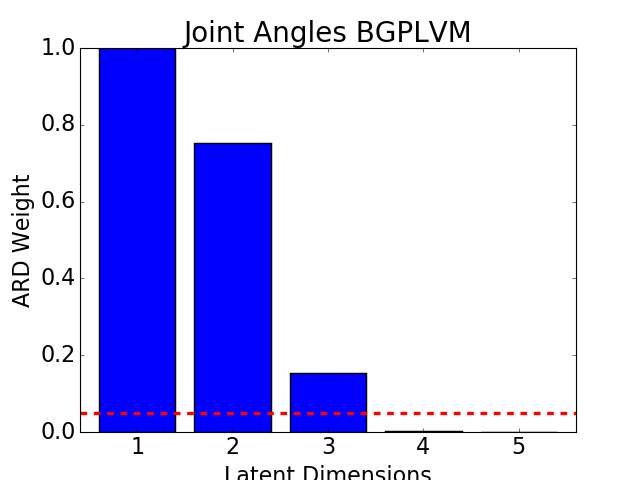

<IPython.core.display.Javascript object>


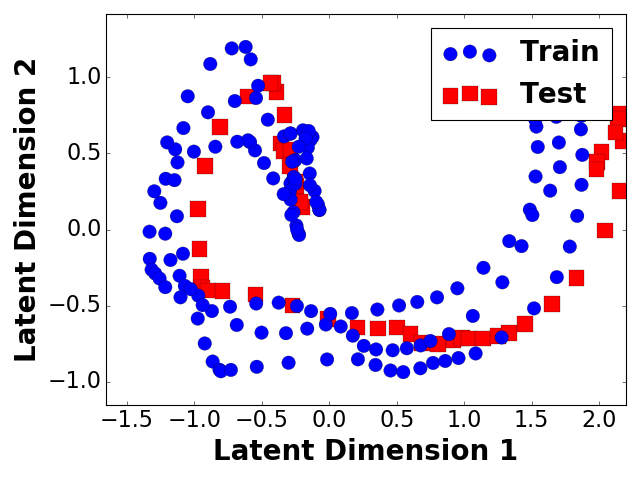

<IPython.core.display.Javascript object>


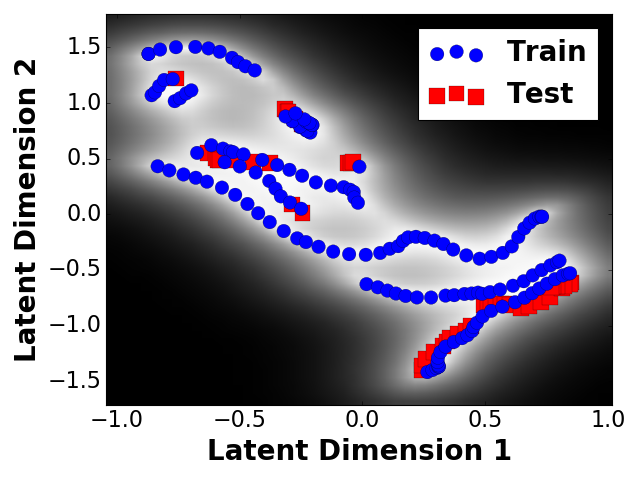

......................................................................................................................................................
..................................................


<IPython.core.display.Javascript object>


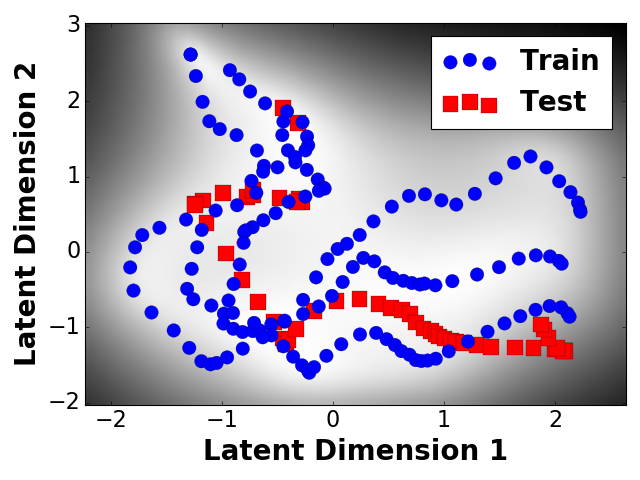

......................................................................................................................................................
..................................................


In [25]:
# visualize the JA models
plotScales(jaModels['BGPLVM'])
pcaLatent(jaModels['PCA'], trainJAData, testJAData, nInfPoints)
gplvmLatent(jaModels['GPLVM'], trainJAData, testJAData, nInfPoints)
bgplvmLatent(jaModels['BGPLVM'], trainJAData, testJAData, nInfPoints)

<IPython.core.display.Javascript object>


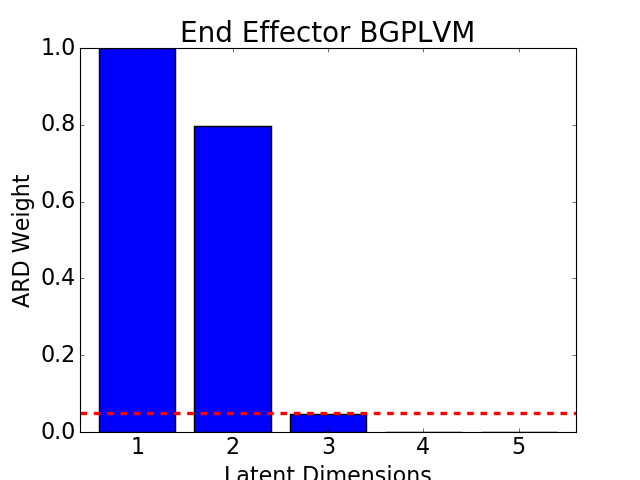

<IPython.core.display.Javascript object>


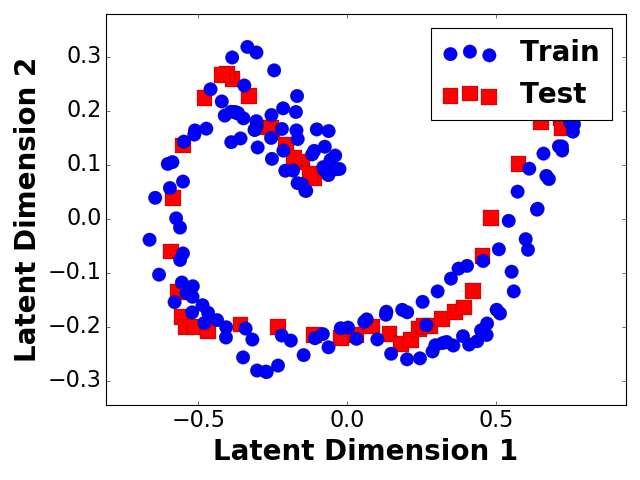

<IPython.core.display.Javascript object>


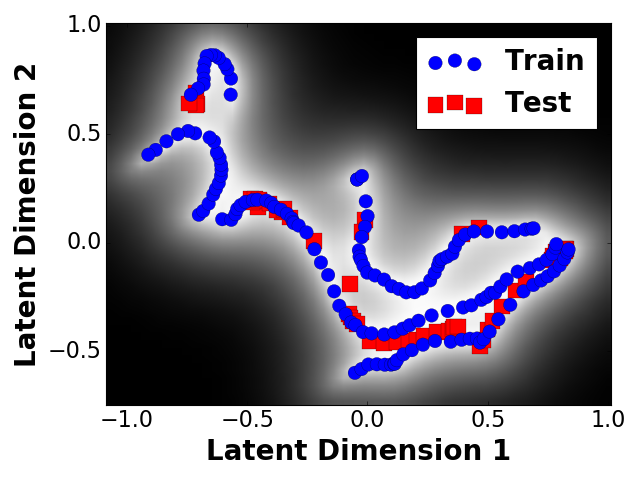

......................................................................................................................................................
..................................................


<IPython.core.display.Javascript object>


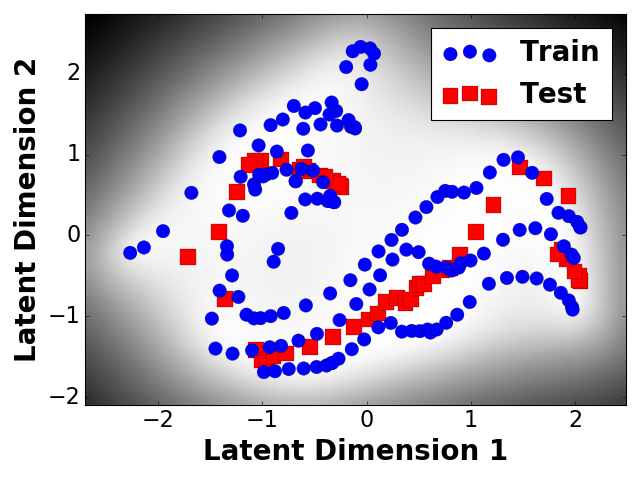

......................................................................................................................................................
..................................................


In [26]:
# visualize the EE models
plotScales(eeModels['BGPLVM'])
pcaLatent(eeModels['PCA'], trainEEData, testEEData, nInfPoints)
gplvmLatent(eeModels['GPLVM'], trainEEData, testEEData, nInfPoints)
bgplvmLatent(eeModels['BGPLVM'], trainEEData, testEEData, nInfPoints)